# Loading Data

In [207]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
import os
import xgboost as xgb
import catboost
from mlxtend.regressor import StackingCVRegressor
import math

from sklearn.metrics import mean_squared_error


warnings.filterwarnings(action='ignore')

In [5]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [62]:
train_df.head()

,Property_ID,room,layout_type,property_type,locality,price,area,furnish_type,bathroom,city,...,floor,pet_friendly,power_backup,washing_machine,air_conditioner,geyser/solar,security_deposit,CCTV/security,lift,neighbourhood
0,42208,3,BHK,Independent House,Palavakkam,33624,1312,Furnished,2,Chennai,...,1,1,0,0,1,0,302616,0,0,300
1,90879,1,BHK,Apartment,Manikonda,9655,1474,Unfurnished,2,Hyderabad,...,17,0,1,0,0,1,19310,0,1,1600
2,99943,3,BHK,Apartment,Jodhpur Park,23699,1837,Semi-Furnished,2,Kolkata,...,10,1,1,1,1,0,118495,0,1,3100
3,113926,1,BHK,Apartment,Chembur,6306,606,Unfurnished,1,Mumbai,...,18,0,0,0,0,0,37836,0,1,300
4,185438,1,BHK,Studio Apartment,Kalewadi Pandhapur Road,12008,498,Semi-Furnished,3,Pune,...,14,0,0,1,1,0,72048,0,1,0


We need to predict the price

In [63]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
Property_ID,134683.0,96036.100777,55565.228125,2.0,47940.0,95950.0,144194.5,192405.0
room,134683.0,2.029677,0.937308,1.0,1.0,2.0,3.0,5.0
price,134683.0,36690.033894,62620.364025,1583.0,12035.5,20856.0,36014.0,799325.0
area,134683.0,1480.388490,1412.464718,81.0,759.0,1114.0,1580.0,13942.0
bathroom,134683.0,2.040488,0.867065,1.0,1.0,2.0,2.0,5.0
parking_spaces,134683.0,0.534388,0.498818,0.0,0.0,1.0,1.0,1.0
floor,134683.0,9.163087,5.957549,0.0,4.0,9.0,15.0,19.0
pet_friendly,134683.0,0.527602,0.499239,0.0,0.0,1.0,1.0,1.0
power_backup,134683.0,0.337051,0.472704,0.0,0.0,0.0,1.0,1.0
washing_machine,134683.0,0.472561,0.499248,0.0,0.0,0.0,1.0,1.0


In [64]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134683 entries, 0 to 134682
Data columns (total 21 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Property_ID       134683 non-null  int64 
 1   room              134683 non-null  int64 
 2   layout_type       134683 non-null  object
 3   property_type     134683 non-null  object
 4   locality          134683 non-null  object
 5   price             134683 non-null  int64 
 6   area              134683 non-null  int64 
 7   furnish_type      134683 non-null  object
 8   bathroom          134683 non-null  int64 
 9   city              134683 non-null  object
 10  parking_spaces    134683 non-null  int64 
 11  floor             134683 non-null  int64 
 12  pet_friendly      134683 non-null  int64 
 13  power_backup      134683 non-null  int64 
 14  washing_machine   134683 non-null  int64 
 15  air_conditioner   134683 non-null  int64 
 16  geyser/solar      134683 non-null  int

The data have no null values, Uff... It eases our work somehow..

##  EDA

In [105]:
train_df.groupby("city")["price"].mean().sort_values(ascending = False)

city
Ahmedabad    43099.677250
Bangalore    39863.151007
Chennai      37694.160345
Delhi        36888.325506
Hyderabad    36681.611672
Kolkata      35341.154084
Mumbai       35078.077745
Pune         32872.992045
Name: price, dtype: float64

In [90]:
train_df.groupby("locality")["price"].mean().sort_values(ascending = False)

locality
Madanayakahalli                  738467.0
Gururaj Society                  651757.0
Malcha                           615142.0
Veerbhadra Nagar                 587449.0
HSR Layout 2nd sector Banglor    569093.0
                                   ...   
Sector 21 Ulwe                     2125.0
Union Park                         2035.0
Teli Galli Cross Road              1980.0
Haranwali                          1903.0
dhanukarwadi                       1850.0
Name: price, Length: 3706, dtype: float64

In [92]:
train_df.groupby("lift")["price"].mean().sort_values(ascending = False)

lift
1    37067.262688
0    36133.872299
Name: price, dtype: float64

In [93]:
train_df.groupby("air_conditioner")["price"].mean().sort_values(ascending = False)

air_conditioner
1    38601.830423
0    32382.049471
Name: price, dtype: float64

In [167]:
train_df.groupby("room")["price"].mean().sort_values(ascending = False) #

room
5    41397.343158
3    40464.908042
2    39158.799468
4    38224.336272
1    31315.240190
Name: price, dtype: float64

In [95]:
train_df.groupby("layout_type")["price"].mean().sort_values(ascending = False)

layout_type
BHK    37215.964206
RK     33674.093505
Name: price, dtype: float64

In [170]:
train_df.groupby("property_type")["price"].mean().sort_values(ascending = False) #

property_type
Apartment            37098.998053
Penthouse            37062.402439
Independent Floor    36889.893114
Independent House    36194.615677
Villa                33765.557926
Studio Apartment     31933.710991
Name: price, dtype: float64

In [102]:
train_df.groupby("furnish_type")["price"].mean().sort_values(ascending = False)

furnish_type
Semi-Furnished    38825.887487
Furnished         38120.696245
Unfurnished       32382.049471
Name: price, dtype: float64

In [173]:
train_df.groupby("bathroom")["price"].mean().sort_values(ascending = False) #

bathroom
3    39391.570786
2    39078.731314
5    38948.659933
4    37462.054904
1    29988.567448
Name: price, dtype: float64

In [107]:
train_df.groupby("parking_spaces")["price"].mean().sort_values(ascending = False)

parking_spaces
1    38243.196685
0    34907.450805
Name: price, dtype: float64

In [108]:
train_df.groupby("floor")["price"].mean().sort_values(ascending = False)

floor
16    38899.809944
18    38510.935795
11    37961.218655
0     37654.527491
6     37610.121735
15    37505.821795
1     37350.864964
17    37312.005060
19    36765.479224
13    36762.949577
14    36625.646580
12    36495.161181
8     36441.067719
7     36288.057345
10    36257.325051
5     35849.441874
4     35724.829656
9     35416.804199
2     35314.952705
3     35143.327617
Name: price, dtype: float64

In [113]:
train_df.groupby("neighbourhood")["price"].mean().sort_values(ascending = False)

neighbourhood
300     40586.465571
400     39761.821670
200     39431.493132
2700    38979.805844
2600    38954.004132
100     38634.830775
1200    38530.276088
900     38196.287975
1100    38181.391966
800     37668.401239
1400    37661.059877
1600    37595.653294
2500    37527.198385
500     37502.316294
3300    37491.350279
600     37483.795802
2300    37230.067928
1300    37118.448941
1500    37106.589969
1000    37003.034431
700     36927.778866
0       36673.676409
2200    36652.111111
2100    36578.822920
2000    36492.902111
3100    36328.817971
2800    36110.582283
1700    35828.119366
3200    35737.374751
3400    35676.346914
3000    35607.115222
2900    35352.777139
2400    35190.812905
3600    34921.799071
3500    34726.159437
1800    34598.136719
3700    34593.203883
1900    34481.107421
3900    34281.926920
3800    34051.574348
4000    33890.530704
Name: price, dtype: float64

In [114]:
train_df.groupby("geyser/solar")["price"].mean().sort_values(ascending = False)

geyser/solar
1    37986.457211
0    35670.848204
Name: price, dtype: float64

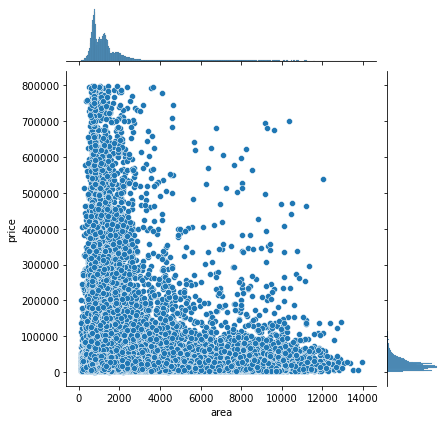

In [99]:
sns.jointplot(x = "area", y = "price", data = train_df)

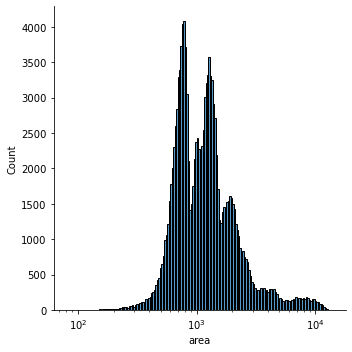

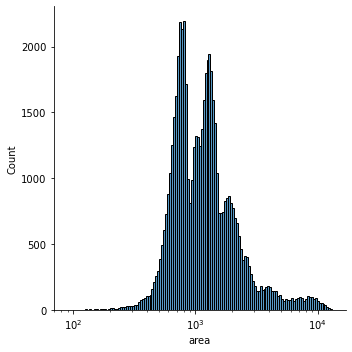

In [158]:
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 8))
sns.displot(train_df["area"], log_scale=10)
sns.displot(test_df["area"], log_scale=10)

<AxesSubplot:xlabel='floor', ylabel='count'>

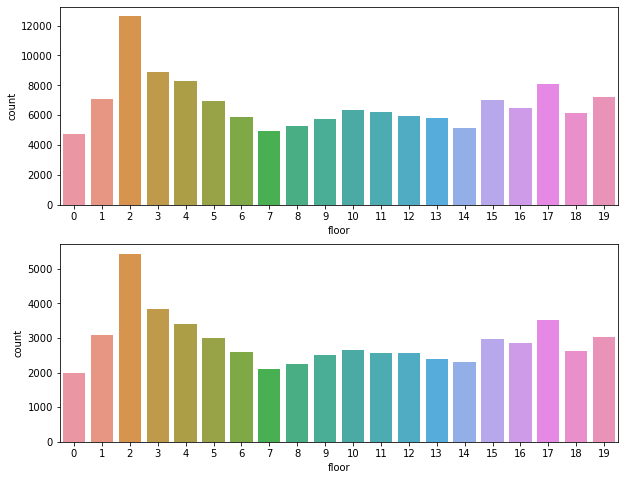

In [157]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 1, 1)
sns.countplot(x="floor", data=train_df)
plt.subplot(2, 1, 2)
sns.countplot(x="floor", data=test_df)

In [213]:
train_df["layout_type"] = LabelEncoder().fit_transform(train_df["layout_type"])
train_df["property_type"] = LabelEncoder().fit_transform(train_df["property_type"])
train_df["locality"] = LabelEncoder().fit_transform(train_df["locality"])
train_df["furnish_type"] = LabelEncoder().fit_transform(train_df["furnish_type"])
train_df["city"] = LabelEncoder().fit_transform(train_df["city"])

In [214]:
train_df["city"].value_counts()

6    46910
3    22826
1    16092
7    15713
0    12976
4     7334
5     6795
2     6037
Name: city, dtype: int64

In [210]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df.drop("price", axis=1), train_df["price"], test_size=0.25, shuffle=True, random_state=42)

In [211]:
from xgboost import XGBRegressor

model_xgb = XGBRegressor()

model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

In [212]:
mean_squared_error(y_test, model_xgb.predict(X_test), squared=False)

28021.567844319088